## This script makes figures using the output of motor_pipeline.ipynb

### Import Packages

In [6]:
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

### Define Paths and Variables

In [103]:
grp_df = pd.read_csv('grp_df_3T_012624.csv')
diag_df = pd.read_csv('diag_df_3T_012624.csv')

# Choose what to analyse
networks = ["SomMot"] 
network = "SomMot"
CESTnetworks = ["avgCEST_SomMot", "ctCEST_SomMot"]
CNB_scores = ["tap_tot"]
CNB_valids = ["tap_valid"] 
diag_scores = ["hstatus"]
demo_scores = ["sex", "age", "race","ethnic","dateDiff"]
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
covariate_age = 'age' 
covariate_sex = 'sex'

### Data Trimming

In [82]:
# Standardize groups and keep only PSD or healthy
grp_df['hstatus'] = grp_df['hstatus'].replace('NC', 'HC')
grp_df['hstatus'] = grp_df['hstatus'].replace('PROR', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('PRO', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('S', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('O', 'Other')
grp_df['hstatus'] = grp_df['hstatus'].replace('Unknown', 'Other')
grp_df['hstatus'] = grp_df['hstatus'].replace('MDD', 'Other')

grp_df = grp_df.dropna(subset=['SomMot', 'avgCEST_SomMot', 'hstatus']) 
value_counts = grp_df['hstatus'].value_counts() 
print(value_counts)

#Exclude tap-tot outliers, which are >2.5 standard deviations from the mean.
grp_df = grp_df[grp_df['BBLID'] != 94703]
grp_df = grp_df[grp_df['BBLID'] != 80557]
#Trim by diagnosis; rename sex variable.
grp_df = grp_df[grp_df['hstatus'] != 'Other']
grp_df['sex'] = np.where(grp_df['sex'] == 1, 'F', 'M')
value_counts = grp_df['hstatus'].value_counts() 
print(value_counts)
print(grp_df)

hstatus
PSY      22
HC       17
Other     4
Name: count, dtype: int64
hstatus
PSY    21
HC     16
Name: count, dtype: int64
    Unnamed: 0   BBLID  Session sex    age  race  ethnic  dateDiff    SomMot  \
2            2  120217    10702   M  24.77   1.0     2.0       8.0  0.414295   
5            5  132179    10780   M  21.81   2.0     2.0       0.0  0.398240   
9            9  116019    10078   M  25.72   2.0     1.0       0.0  0.553280   
11          11   96902    11870   M  20.76   1.0     1.0       6.0  0.669169   
12          12  118864    11724   M  19.77   2.0     1.0      18.0  0.396644   
13          13   20325    11667   M  23.07   5.0     2.0      14.0  0.533364   
17          17  125073    11756   M  26.21   2.0     2.0      26.0  0.555645   
18          18  121085    10973   M  20.84   1.0     2.0      14.0  0.594239   
20          20   93292    10306   M  25.32   2.0     2.0       0.0  0.445644   
21          21  116354    11647   M  23.47   2.0     2.0      53.0  0.469042

### Subjects Excluded:

#### Only 4 people in other group. Given reviews on meta-analysis and small "Other" sample, exclude from present analysis.
#### Exclude outliers for taptot (i.e. >2.5 sd from sample mean of 106)
#### 
#### 



### Demographics

In [77]:
age = grp_df.groupby("hstatus").agg(
    Age_avg = ("age", "mean"),
    Age_std = ("age", "std"),
)
sex_counts = grp_df.groupby('hstatus')['sex'].value_counts()  
print(sex_counts)
race_counts = grp_df.groupby('hstatus')['race'].value_counts()    
print(race_counts)

# Table 1 of manuscript should have:
# Average age (SD)
# Male/female
# Racial demographics
# Psychosis spectrum severity score?
# Medications?
# Comorbidities

hstatus  sex
HC       F       8
         M       8
PSY      M      15
         F       6
Name: count, dtype: int64
hstatus  race
HC       1.0      9
         2.0      6
         5.0      1
PSY      2.0     12
         1.0      6
         5.0      3
Name: count, dtype: int64


### Histograms

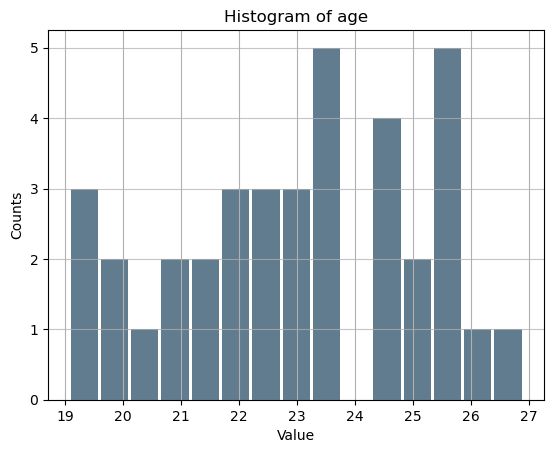

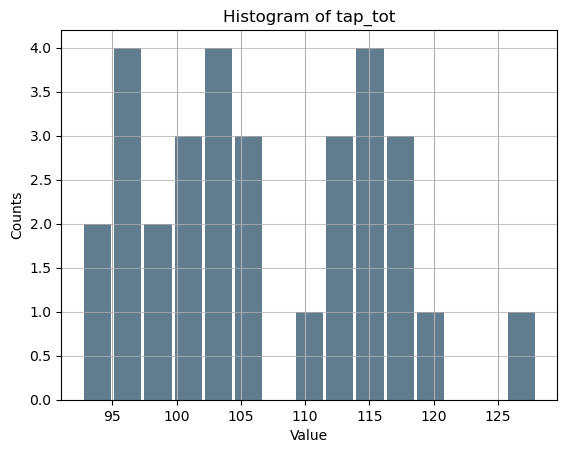

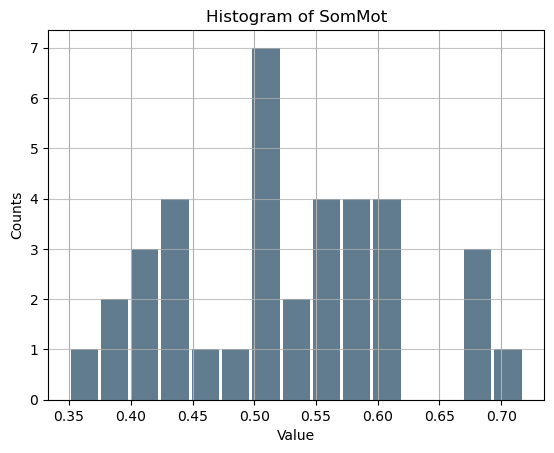

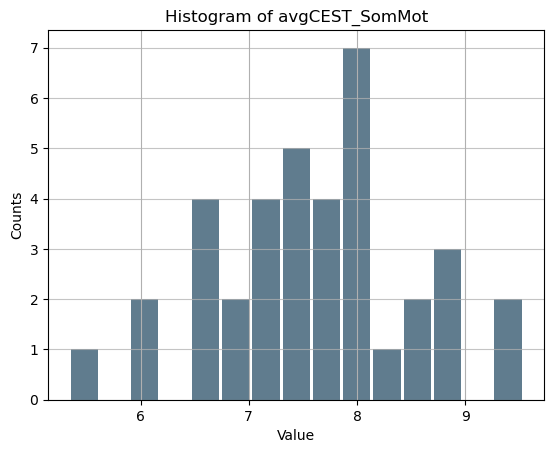

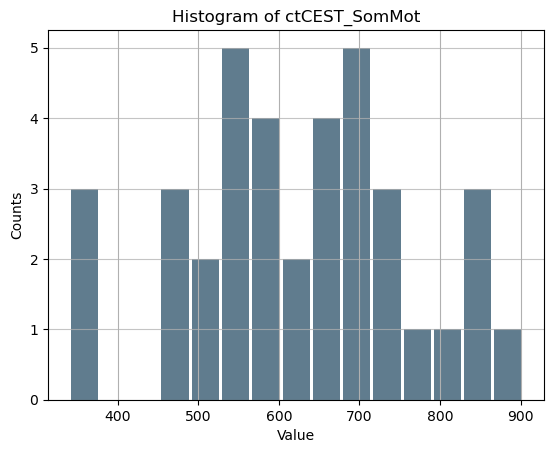

106.89246741935483
8.872087718677406


In [78]:
# Histograms
vars = ['age', 'tap_tot', 'SomMot', 'avgCEST_SomMot', 'ctCEST_SomMot']     
for var in vars:
    plt.figure()
    input = pd.Series(grp_df[var])
    input.plot.hist(grid=True, bins=15, rwidth=0.9, color='#607c8e')
    plt.title('Histogram of ' + var)
    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

print(grp_df['tap_tot'].mean())
print(grp_df['tap_tot'].std())

### Assess Demographic Variables

['avgCEST_SomMot', 'SomMot']
avgCEST_SomMot


/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


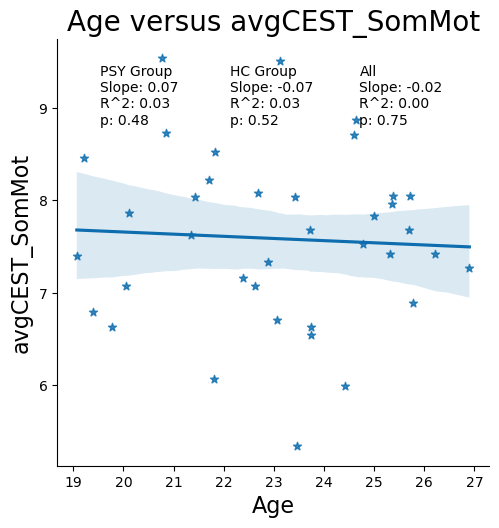

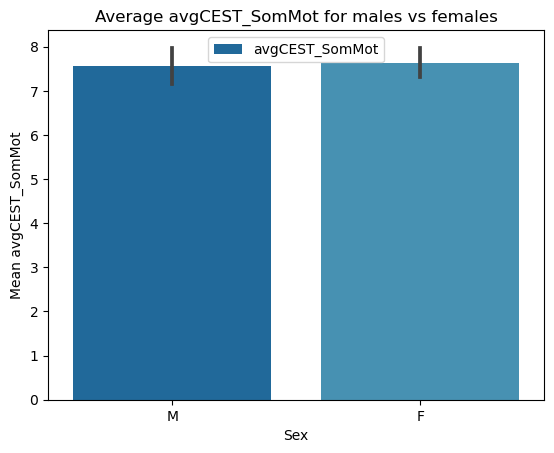

avgCEST_SomMott test: t=-0.2069802332014774, p=0.8372247955790283
SomMot


/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


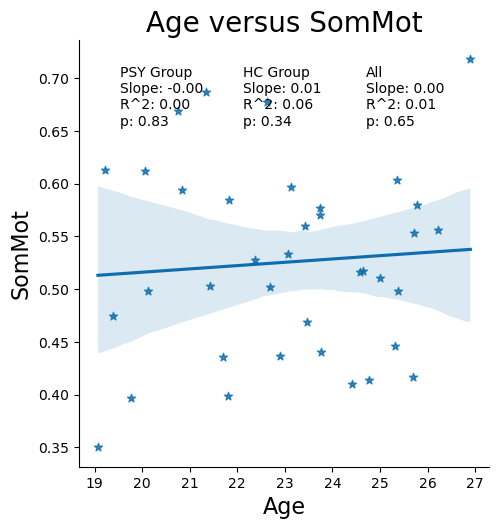

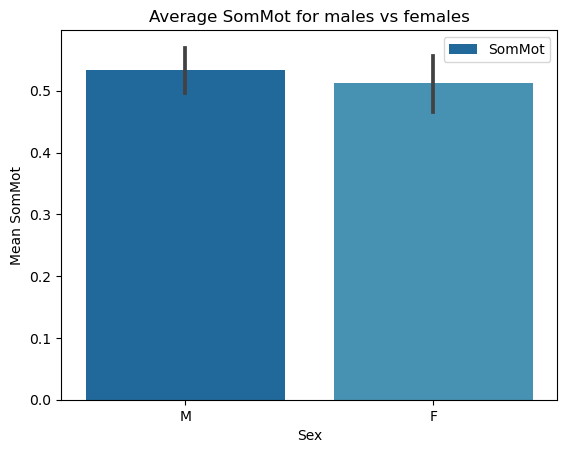

SomMott test: t=0.6482306776080694, p=0.5210661196977978


In [83]:
# Quality control figures

network="SomMot"
cestcol = "avgCEST_" + network
metrics = [cestcol, network]
print(metrics)
for metric in metrics:
    print(metric)
    graph_df = grp_df
    graph_df = graph_df.dropna(subset=[network, cestcol, 'hstatus'])
    # Create a linear regression model for fcon
    color = colors.loc[colors['Network'] == network, 'Color'].values[0]
    sns.set_palette(color)
    plot = sns.lmplot(x='age', y=metric, data=graph_df, markers= "*") #hue='hstatus', 
    plt.xlabel("Age", fontsize=16)
    plt.ylabel(metric, fontsize=16)
    plt.title('Age versus ' + metric, fontsize = 20)
    # Generate and add slope, r2 and p for subset 1
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', 'age'], graph_df.loc[graph_df['hstatus'] == 'PSY', metric])
    plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    #     # Generate and add slope, r2 and p for subset 2
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', 'age'], graph_df.loc[graph_df['hstatus'] == 'HC', metric])
    plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for all data
    slope, intercept, r_value, p_value, std_err = linregress(graph_df['age'], graph_df[metric])
    plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    plt.show() 
    
    # Bar plots assessing sex differences
    sns.barplot(x='sex', y=metric, data=graph_df, estimator='mean', label=metric) #yerr=avg_df[cestcol + '_std'],
    plt.xlabel('Sex')
    plt.ylabel('Mean ' + metric)
    plt.title('Average ' + metric + ' for males vs females')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(graph_df.loc[graph_df['sex'] == 'M', metric],
                                     graph_df.loc[graph_df['sex'] == 'F', metric])
    print(metric + 't test: t=' + str(t_statistic) + ', p=' + str(p_value))
    

### Main Figures

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


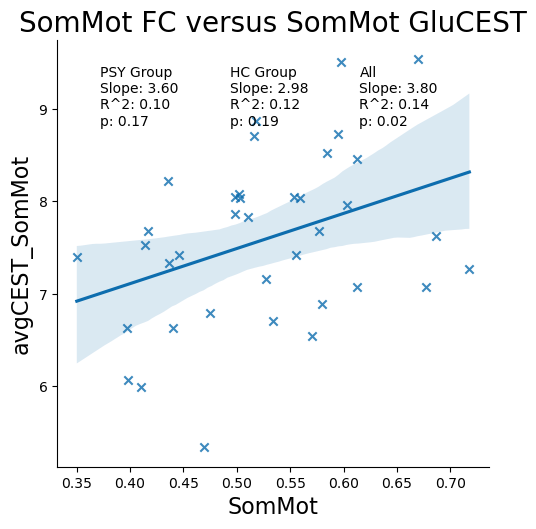

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


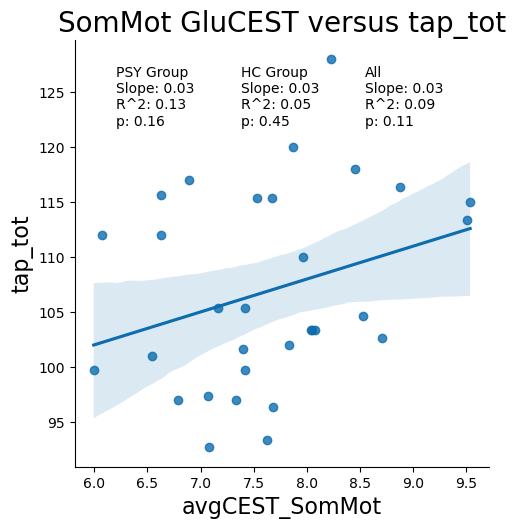

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


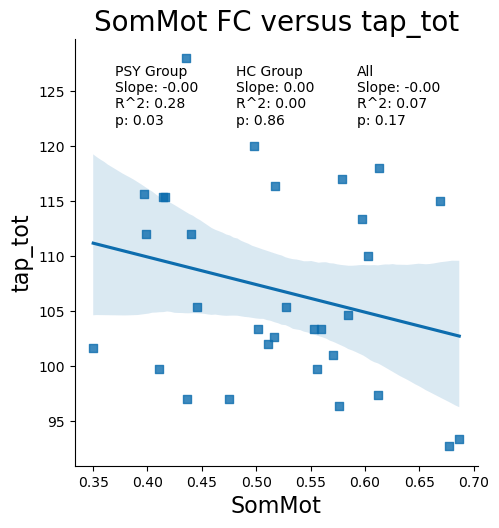

  hstatus_  avgCEST_SomMot_mean  avgCEST_SomMot_std  SomMot_mean  SomMot_std
0       HC             7.939347            0.901972     0.546046    0.105422
1      PSY             7.319434            0.869048     0.509880    0.074961


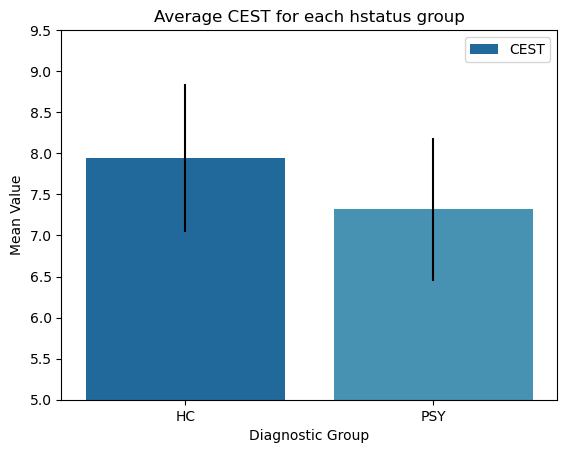

CEST t test: t=-2.114886879031197, p=0.04163228881599582


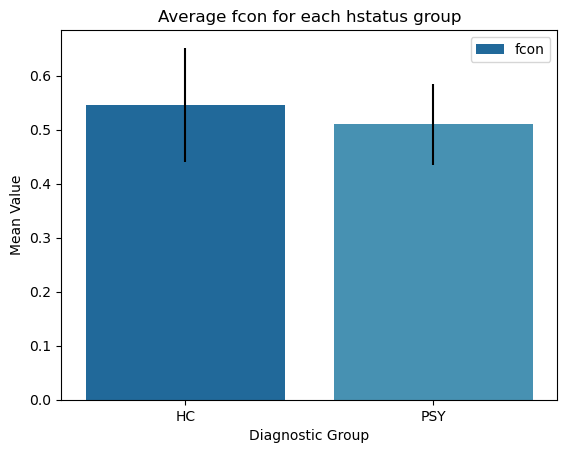

FC t test: t=-1.2204612383889522, p=0.23044927065415896


In [62]:
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 


# Create a scatter plot with a linear regression line
for network in networks:
    cestcol = "avgCEST_" + network
    #graph_df = grp_df[grp_df['hstatus'] != 'Other']
    graph_df = grp_df
    graph_df = graph_df.dropna(subset=[network, cestcol, 'hstatus'])
    # Create a linear regression model for fcon
    color = colors.loc[colors['Network'] == network, 'Color'].values[0]
    sns.set_palette(color)
    plot = sns.lmplot(x=network, y=cestcol, data=graph_df, markers= "x") #hue='hstatus', 
    if network == "SalVentAttn":
        plt.xlabel("SN", fontsize=16)
        plt.ylabel("avgCEST_SN", fontsize=16)
        plt.title('SN FC versus SN GluCEST', fontsize = 20)
    else:
        plt.xlabel(network, fontsize=16)
        plt.ylabel(cestcol, fontsize=16)
        plt.title(network + ' FC versus ' + network + ' GluCEST' , fontsize = 20)
    # Generate and add slope, r2 and p for subset 1
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', network], graph_df.loc[graph_df['hstatus'] == 'PSY', cestcol])
    plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
#     # Generate and add slope, r2 and p for subset 2
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', network], graph_df.loc[graph_df['hstatus'] == 'HC', cestcol])
    plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for all data
    slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    plt.show() 

    # Create CNB correlation plot for each network fcon and cest 
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, 'hstatus'])
        # Add labels and a title to the plot
        plot = sns.lmplot(x=cestcol, y=CNB_score,data=graph_df) # hue='hstatus',
        if network == "SalVentAttn":
            plt.xlabel("avgCEST_SN", fontsize=16)
            plt.title('SN GluCEST versus ' + CNB_score, fontsize = 20)
        else: 
            plt.xlabel(cestcol, fontsize=16)
            plt.title(network + ' GluCEST versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', CNB_score], graph_df.loc[graph_df['hstatus'] == 'PSY', cestcol])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', CNB_score], graph_df.loc[graph_df['hstatus'] == 'HC', cestcol])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[cestcol])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()    

        #graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, network, 'hstatus'])
        # Add labels and a title to the plot
        plot = sns.lmplot(x=network, y=CNB_score, data=graph_df, markers= "s") #hue='hstatus',
        if network == "SalVentAttn":
            plt.xlabel("SN", fontsize=16)
            plt.title('SN FC versus ' + CNB_score, fontsize = 20)
        else:
            plt.xlabel(network, fontsize=16)
            plt.title(network + ' FC versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', CNB_score], graph_df.loc[graph_df['hstatus'] == 'PSY', network])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', CNB_score], graph_df.loc[graph_df['hstatus'] == 'HC', network])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[network])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()  

    # Make bar graph comparing diagnostic groups
    avg_df = grp_df.groupby('hstatus').agg({cestcol: ['mean', 'std'], network: ['mean', 'std']}).reset_index()
    # Flatten the multi-level columns
    avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
    print(avg_df)

    
    # Plot CEST bar graph with error bars
    sns.barplot(x='hstatus_', y=cestcol + '_mean', data=avg_df, yerr=avg_df[cestcol + '_std'], label='CEST')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.ylim(5, 9.5)
    plt.title('Average CEST for each hstatus group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['hstatus'] == 'PSY', 'avgCEST_SomMot'],
                                     grp_df.loc[grp_df['hstatus'] == 'HC', 'avgCEST_SomMot'])
    print('CEST t test: t=' + str(t_statistic) + ', p=' + str(p_value))
    # Plot fcon bar graph with error bars
    sns.barplot(x='hstatus_', y=network + '_mean', data=avg_df, yerr=avg_df[network + '_std'], label='fcon')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.title('Average fcon for each hstatus group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['hstatus'] == 'PSY', 'SomMot'],
                                     grp_df.loc[grp_df['hstatus'] == 'HC', 'SomMot'])
    print('FC t test: t=' + str(t_statistic) + ', p=' + str(p_value))


### Multiple Linear Regressions

SomMot
CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:         avgCEST_SomMot   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.791
Date:                Fri, 02 Feb 2024   Prob (F-statistic):              0.163
Time:                        14:29:43   Log-Likelihood:                -57.188
No. Observations:                  48   AIC:                             122.4
Df Residuals:                      44   BIC:                             129.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'SomMot' is not defined
    avgCEST_SomMot ~ SomMot + age + sex
                     ^^^^^^

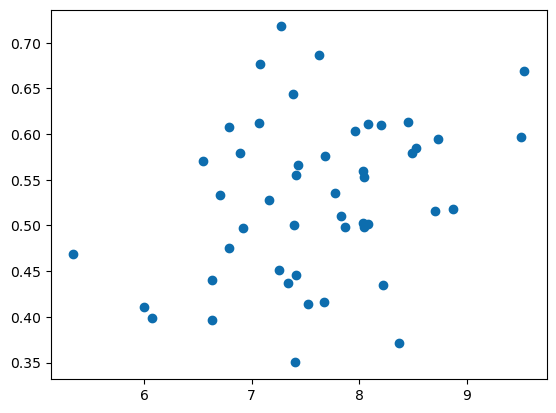

In [105]:
graph_df = grp_df

print(network)

formula = f'{cestcol} ~ {network} + {covariate_age} + {covariate_sex}'
model = smf.ols(formula=formula, data=graph_df).fit()
print('CEST-FC Association in all') 
print(model.summary())
    
fig, ax = plt.subplots()
ax.scatter(graph_df[cestcol], graph_df[network], label='Actual Data')
# Generate x values for the line
x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                       covariate_age: np.mean(graph_df[covariate_age])})  # Use mean value for the network variable
# Predictions for the regression line
y_line = model.predict(x_line)
# Plot the regression line
ax.plot(x_line[cestcol], y_line, color='red', label='Regression Line')
ax.set_xlabel(cestcol)
ax.set_ylabel(network)
ax.set_title('Multiple Linear Regression Plot for ' + network + ' & ' + network)
ax.legend()
plt.show()      


SomMot
    Unnamed: 0   BBLID  Session sex    age  race  ethnic  dateDiff    SomMot  \
11          11   96902    11870   M  20.76   1.0     1.0       6.0  0.669169   
12          12  118864    11724   M  19.77   2.0     1.0      18.0  0.396644   
18          18  121085    10973   M  20.84   1.0     2.0      14.0  0.594239   
22          22   90281    10147   M  22.89   1.0     2.0      52.0  0.436747   
27          27  106880    10302   F  22.62   2.0     2.0       0.0  0.677187   
28          28   94288    11948   F  22.68   1.0     2.0      56.0  0.501603   
32          32  121407     9257   M  25.78   2.0     2.0       0.0  0.579389   
33          33  102041    10603   F  23.43   1.0     2.0       0.0  0.559427   
35          35   20303    12276   F  19.22   1.0     2.0      17.0  0.612904   
42          42  115783    11653   M  26.90   2.0     2.0      19.0  0.717729   
45          45   85743    10974   M  23.12   1.0     2.0       2.0  0.597216   
52          52   93734    10092  

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'SomMot' is not defined
    avgCEST_SomMot ~ SomMot + age + sex
                     ^^^^^^

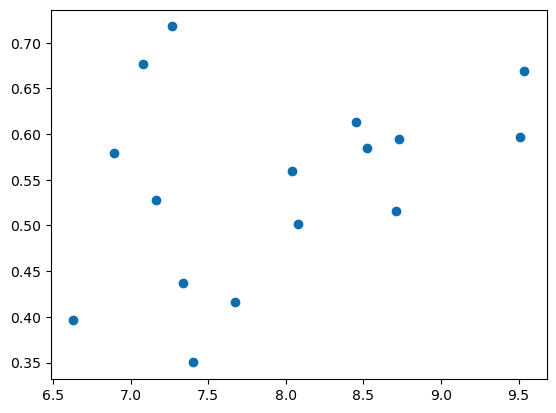

In [101]:
# First, replicate main findings using multiple linear regression to control for age and sex.p


# First, CEST vs FC regression:

statuses = ['HC', 'PSY']
# Create a figure outside the loop to have a single plot
fig, ax = plt.subplots()
print(network)

for status in statuses:
    graph_df = grp_df[grp_df['hstatus'] == status]
    print(graph_df)
    formula = f'{cestcol} ~ {network} + {covariate_age} + {covariate_sex}'
    model = smf.ols(formula=formula, data=graph_df).fit()
    print('CEST-FC Association in ' + status) 
    print(model.summary())

    # Plotting the regression line
    ax.scatter(graph_df[cestcol], graph_df[network], label='Actual Data')
    # Generate x values for the line
    x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                           covariate_age: np.mean(graph_df[covariate_age])})
                            #covariate_age: np.linspace(graph_df[covariate_age].min(),graph_df[covariate_age].max(), 100)})  # Use mean value for the network variable
    # Predictions for the regression line
    y_line = model.predict(x_line)
    # Plot the regression line
    ax.plot(x_line[cestcol], y_line, color='red', label=f'Regression Line (Status: {status})')
    
ax.set_xlabel(cestcol)
ax.set_ylabel(CNB_score)
ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + network)
ax.legend()
plt.show()


               
          # Plotting the regression line
        fig, ax = plt.subplots()
        ax.scatter(graph_df[cestcol], graph_df[CNB_score], label='Actual Data')
        # Generate x values for the line
        x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                               network: np.mean(graph_df[network])})  # Use mean value for the network variable
        # Predictions for the regression line
        y_line = model.predict(x_line)
        # Plot the regression line
        ax.plot(x_line[cestcol], y_line, color='red', label='Regression Line')
        ax.set_xlabel(cestcol)
        ax.set_ylabel(CNB_score)
        ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + network)
        ax.legend()
        plt.show()      

         




SomMot & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.383
Date:                Fri, 02 Feb 2024   Prob (F-statistic):              0.267
Time:                        13:28:15   Log-Likelihood:                -109.69
No. Observations:                  31   AIC:                             225.4
Df Residuals:                      28   BIC:                             229.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         88.292

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
when evaluating factor age, I got 1 columns instead of the 2 I was expecting
    tap_tot ~ avgCEST_SomMot + age
                               ^^^

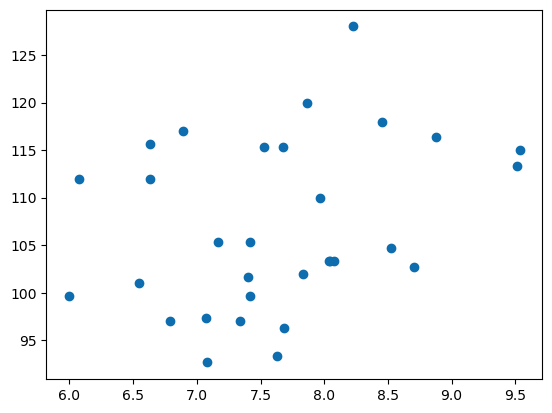

In [71]:

        

    
    
    
    
    
    
    
    
        
for metric in metrics:
    for CNB_score in CNB_scores:
        # Define x values and target variable
        #X = graph_df[[cestcol, network]]
       # Y = graph_df[CNB_score]
        
        ##################################
        # Define formula and model
        formula = f'{CNB_score} ~ {metric} + {covariate_age}'
        model = smf.ols(formula=formula, data=graph_df).fit()
        
       # model = smf.ols.from_formula('CNB_score ~ metric + age', graph_df).fit()
        print('\n\n\n' + network + ' & ' + CNB_score) 
        print(model.summary())

        # Plotting the regression line
        fig, ax = plt.subplots()
        ax.scatter(graph_df[metric], graph_df[CNB_score], label='Actual Data')
        # Generate x values for the line
        x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                               network: np.mean(graph_df[network])})  # Use mean value for the network variable
        # Predictions for the regression line
        y_line = model.predict(x_line)
        # Plot the regression line
        ax.plot(x_line[cestcol], y_line, color='red', label='Regression Line')
        ax.set_xlabel(cestcol)
        ax.set_ylabel(CNB_score)
        ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + network)
        ax.legend()
        plt.show()
        

        
        
        
        




SomMot & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.014
Date:                Fri, 02 Feb 2024   Prob (F-statistic):              0.394
Time:                        12:59:10   Log-Likelihood:                -51.258
No. Observations:                  14   AIC:                             108.5
Df Residuals:                      11   BIC:                             110.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         43.512

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


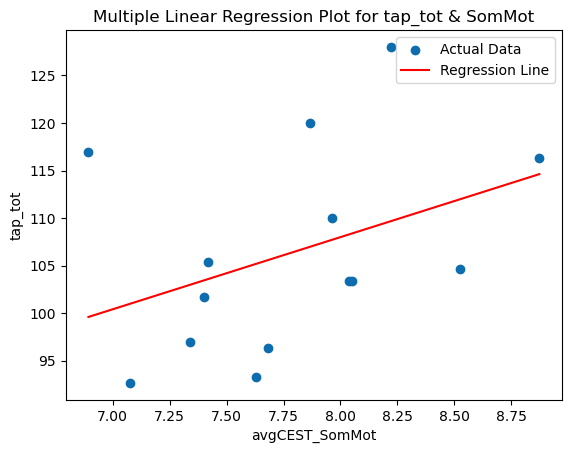

In [43]:


















colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

anova_tables = []
# Create a scatter plot with a multiple linear regression 
for network in networks:
    cestcol = "avgCEST_" + network
    # Create a linear regression model for fcon
   # color = colors.loc[colors['Network'] == network, 'Color'].values[0]
   # sns.set_palette(color)

    # Create CNB correlation plot for each network fcon and cest 
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
        graph_df = graph_df[[CNB_score, cestcol, network]]
        # Define x values and target variable
        X = graph_df[[cestcol, network]]
        Y = graph_df[CNB_score]

        ##################################
        # Define formula and model
        formula = f'{CNB_score} ~ {cestcol} + {network}'
        model = smf.ols(formula=formula, data=graph_df).fit()
        print('\n\n\n' + network + ' & ' + CNB_score) 
        print(model.summary())

        # Plotting the regression line
        fig, ax = plt.subplots()
        ax.scatter(graph_df[cestcol], graph_df[CNB_score], label='Actual Data')
        # Generate x values for the line
        x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                               network: np.mean(graph_df[network])})  # Use mean value for the network variable
        # Predictions for the regression line
        y_line = model.predict(x_line)
        # Plot the regression line
        ax.plot(x_line[cestcol], y_line, color='red', label='Regression Line')
        ax.set_xlabel(cestcol)
        ax.set_ylabel(CNB_score)
        ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + network)
        ax.legend()
        plt.show()

### 3D Plot Troubleshooting

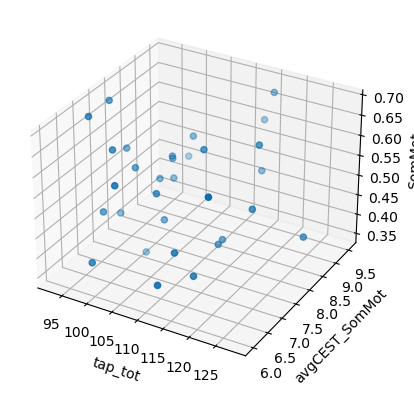

In [38]:
# BBS
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

# Create a scatter plot with a multiple linear regression 
for network in networks:
    cestcol = "avgCEST_" + network
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
        graph_df = graph_df[[CNB_score, cestcol, network]]
        # Define x values and target variable
        X = graph_df[[cestcol, network]]
        Y = graph_df[CNB_score]

        ##################################
        fig = plt.figure()
        ax = fig.add_subplot(111, projection = '3d')
        ax.scatter(graph_df[CNB_score], graph_df[cestcol], graph_df[network])
        ax.set_xlabel(CNB_score)
        ax.set_ylabel(cestcol)
        ax.set_zlabel(network)
        plt.show()

In [ ]:
###Save Output

In [39]:
!jupyter nbconvert --to html motor_figures.ipynb --output motor_figures_3T.html

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook motor_figures.ipynb to html
[NbConvertApp] Writing 1101856 bytes to motor_figures_3T.html
